# ARIMA Model for Forecasting
## 1. Explore Dataset

In [1]:
# Load packages

import os
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pmdarima as pm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [2]:
# Read in dataset

input_folder = f"{os.getcwd()}"
df_proc = pd.read_excel(f"{input_folder}/ffiec031_processed.xlsx")

In [3]:
# Function to select a sample MDRM and set report date as an index

def process_ts_data(ts_data: pd.DataFrame, mdrm: str) -> pd.DataFrame:
    ts_df = ts_data[ts_data['MDRM'] == mdrm].reset_index(drop=True)
    ts_df2 = ts_df.drop(columns=['MDRM']).set_index('ReportDate').dropna()
    return ts_df2

In [4]:
# Select a sample MDRM: RCFA3792 (Total Capital)

df = process_ts_data(df_proc, 'RCFA3792')

In [5]:
# Display dataset info and first 5 rows

display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2014-03-31 to 2024-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   43 non-null     float64
dtypes: float64(1)
memory usage: 688.0 bytes


None

,Value
ReportDate,
2014-03-31,140765000.0
2014-06-30,140709000.0
2014-09-30,140360000.0
2014-12-31,161623000.0
2015-03-31,161662000.0


<AxesSubplot:xlabel='ReportDate'>

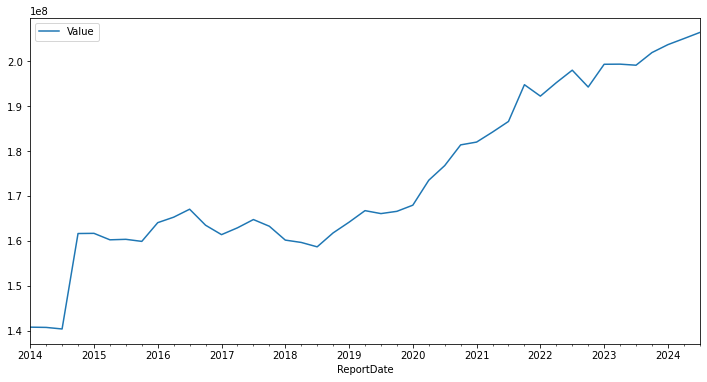

In [6]:
# Display reporting balances over time

df.plot(figsize=(12, 6))

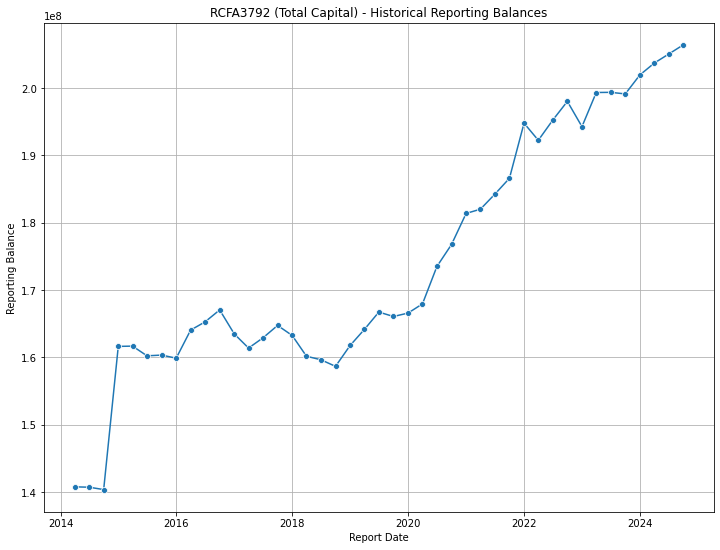

In [7]:
# Plot using seaborn

plt.figure(figsize=(12, 9))
sns.lineplot(x='ReportDate', y='Value', data=df, marker='o')

plt.xlabel("Report Date")
plt.ylabel("Reporting Balance")
plt.title("RCFA3792 (Total Capital) - Historical Reporting Balances")
plt.grid(True)
plt.show()

Based on the observation of the time-serie plot above, it has a strong upward trend but no sign of seasonality, which is assumed to be non-stationary.

In [8]:
# Split dataset into a training (80%) and a test (20%) set 

train_size = int(len(df)*0.8)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

## 2. Check for stationarity of time series
### 2.1. Time Series Plot
* See a time series plot above.

### 2.2. ACF and PACF Plot
* ACF (AutoCrrelation Function) is the correlation of the time series with its lags.
* PACF (Partial AutoCorrelation Function) is the partial correlation of the time series with its lags, after revmoing the effect of lower-order-lags between them.

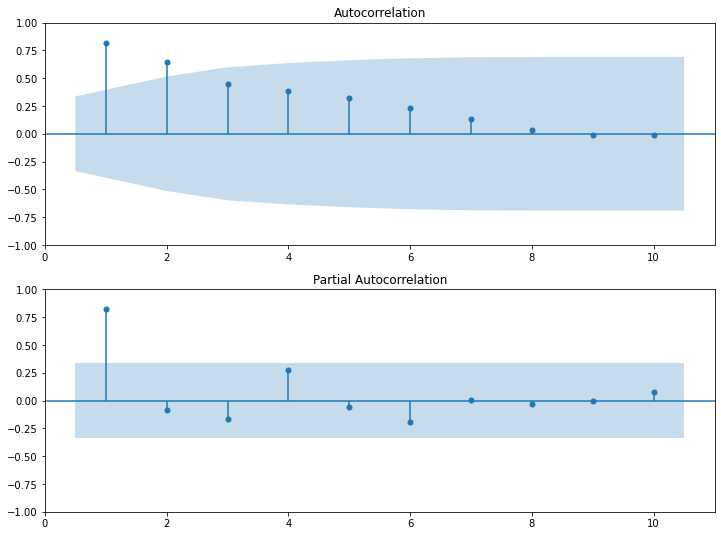

In [9]:
# Plot ACF and PACF of a training set

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
plot_acf(df_train, lags=10, zero=False, ax=ax1)
plot_pacf(df_train, lags=10, zero=False, ax=ax2)
plt.show()

### 2.3. Augmented Dickey-Fuller (ADF) test
* Null hypothesis: there is a unit root; a time series is non-stationary.

In [10]:
# Check stationarity by performing Augmented Dicky Fuller test

def check_stationary(ts_data: pd.DataFrame, column: str) -> str:
    result = adfuller(ts_data[column])
    
    if result[1] < 0.05:
        print(f"p-value: {result[1].round(6)} - Time series is stationary.")
    else:
        print(f"p-value: {result[1].round(6)} - Time series is NOT stationary.")
        
check_stationary(df, 'Value')

p-value: 0.968987 - Time series is NOT stationary.


### 2.4. Transform to stationary: Differencing

<AxesSubplot:xlabel='ReportDate'>

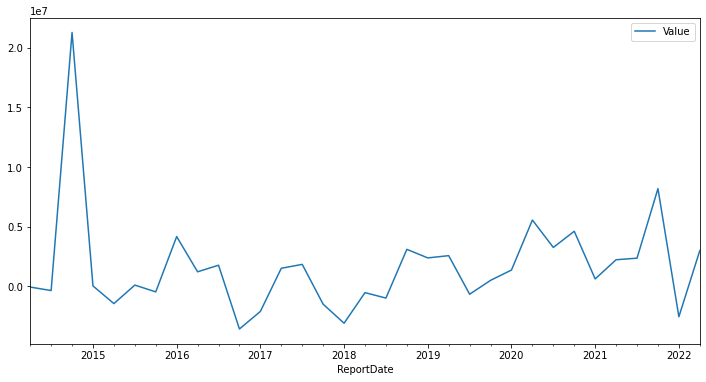

In [11]:
# Try 1-differencing on a training set
df_train_diff = df_train.diff().dropna() # drop a NaN value in the first row

# Plot 1-differened dataset
df_train_diff.plot(figsize=(12, 6))

In [12]:
# Perform ADF test to check for stationarity

check_stationary(df_train_diff, 'Value')

p-value: 0.364508 - Time series is NOT stationary.


<AxesSubplot:xlabel='ReportDate'>

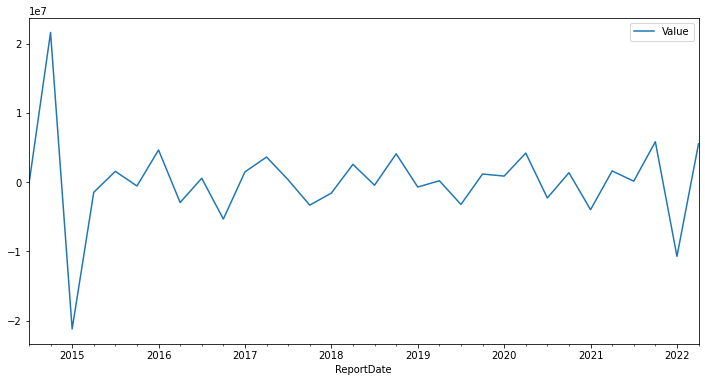

In [13]:
# Try 2-differencing on a training set
df_train_diff2 = df_train_diff.diff().dropna()

# Plot 2-differencing dataset
df_train_diff2.plot(figsize=(12, 6))

In [14]:
# Perform ADF test to check for stationary

check_stationary(df_train_diff2, 'Value')

p-value: 2e-06 - Time series is stationary.


From taking 2 differencing, a model order of d (Integrated; a number of times the time series is differenced) should be 2. __ARIMA(p, 2, q)__

## 3. Determine ARIMA model orders p, q
* 2-differenced train data will be used for modeling, so let's look at the ACF and PACF plot of 2-differenced train data to determine model order of p and q.
* Rule of thumbs to determine a model order of p and q
    * If the PACF plot has a significant spike at lag p, but not beyond; the ACF plot decays more gradually, then it may suggest __ARIMA(p, d, 0)__.
    * If the ACF plot has a significant spike at lag q, but not beyond; the PACF plot decays more gradually, then it may suggest __ARIMA(0, d, q)__.

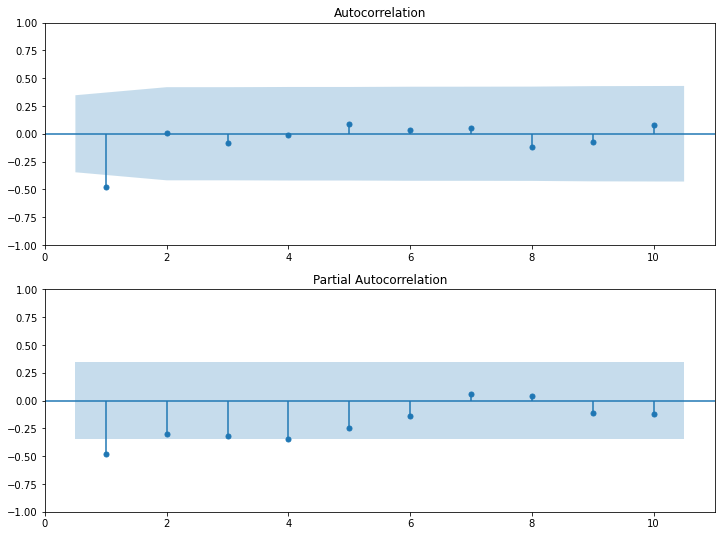

In [15]:
# Plot ACF and PACF of 2-differenced training dataset

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,9))
plot_acf(df_train_diff2, lags=10, zero=False, ax=ax1)
plot_pacf(df_train_diff2, lags=10, zero=False, ax=ax2)
plt.show()

* __Suggested model order of (p, q) = (0, 1)__
* Rationale: The ACF plot has a significant spike at lag 1, but not beyond and the PACF plot decays more gradually.
* Therefore, __the final model order of (p, d, q) should be (0, 2, 1)__

## 4. Fit ARIMA model

In [16]:
# Fit a model
model = ARIMA(df_train, order=(0,2,1))
model_fit = model.fit()

# Print model fit results
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   34
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -575.234
Date:                Sun, 16 Feb 2025   AIC                           1154.467
Time:                        11:23:39   BIC                           1157.399
Sample:                    03-31-2014   HQIC                          1155.439
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0433      0.010     -4.435      0.000      -0.062      -0.024
sigma2      9.114e+12   1.64e-16   5.57e+28      0.000    9.11e+12    9.11e+12
Ljung-Box (L1) (Q):                  10.40   Jarque-

__AIC - Akaike Information Criterion__
* A metric that tells us how good a model is.
* `Lower AIC` indicates `a better model`.
* AIC also penalizes models which have lots of parameters.
    * AIC likes to choose simple models with lower order, which prevents from overfitting to the training data.
    
__BIC - Bayesian Information Criterion__
* Very similar to AIC.
* `Lower BIC` indicates `a better model`.
* BIC penalizes overly complex models.

__AIC vs BIC__
* Difference is `how much they pernalize model complexity`.
* BIC penalizes additional model orders more than AIC, so BIC will suggest a simpler model.
* __If a goal is to identify good predictive model__, __AIC__ should be used.
* __If a goal is to identify good explanatory models__, __BIC__ should be used.

## 5. Model Diagnostics
* How good is the final model?
* To diagnose a model, focus on the residuals to the trianing data.
* `residuals` are the difference between the model's one-step-ahead predictions and the real values of the time series.
* If a model fits well, the residuals will be `white Gaussian noise` centered on zero.
* `Prob(Q)`: p-value for null hypothesis that residuals are uncorrelated.
* `Prob(JB)`: p-value for null hypothesis that residuals are normal.

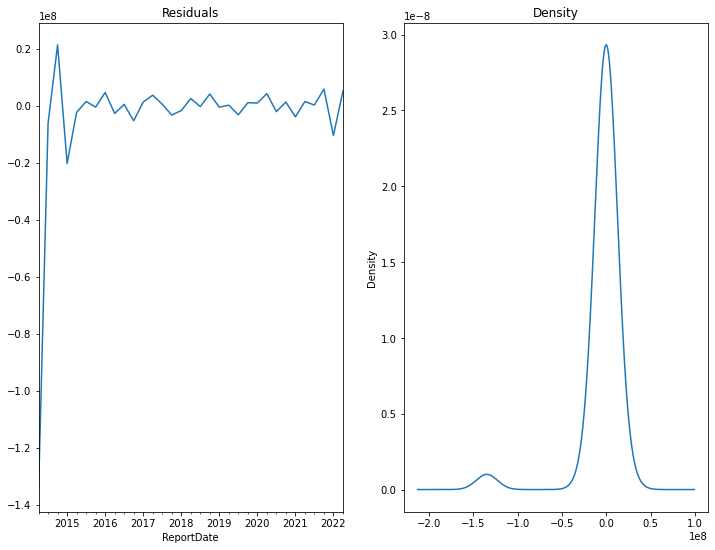

In [17]:
# Plot residuals

resids = model_fit.resid[1:]

fig, ax = plt.subplots(1, 2, figsize=(12, 9))
resids.plot(title='Residuals', ax=ax[0])
resids.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

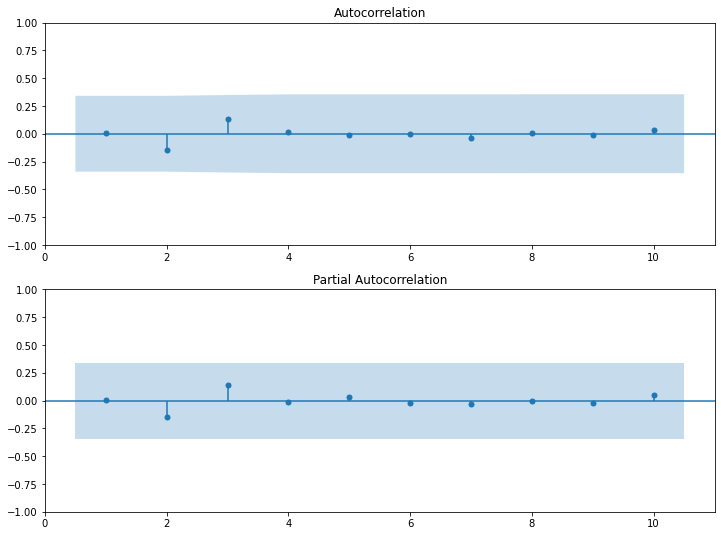

In [18]:
# Plot ACF and PACF of residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
plot_acf(resids, lags=10, zero=False, ax=ax1)
plot_pacf(resids, lags=10, zero=False, ax=ax2)
plt.show()

No significant spikes from both ACF and PACF plot, therefore the residuals look like white noise.

## 6. Make time series predictions

In [19]:
# Make forecasts with test set

forecast_test = model_fit.forecast(len(df_test))

<AxesSubplot:xlabel='ReportDate'>

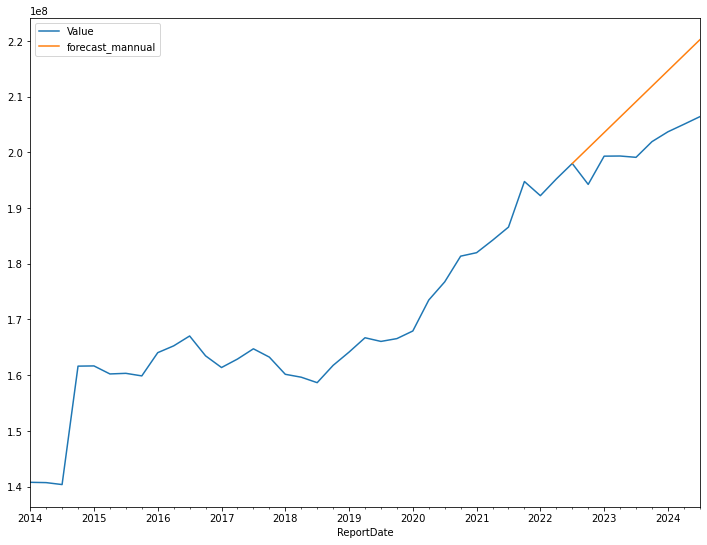

In [20]:
# Plot forecasts with entire dataset

df['forecast_mannual'] = [None]*len(df_train) + list(forecast_test)
df.plot(figsize=(12, 9))

The forecast follows a previous momuntum and shows a linear upward trend line.

## 7. Optional: Auto-fit the ARIMA model

In [21]:
# Build a auto-fit ARIMA model using pmdariam package

auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True)

In [22]:
# Print model fit results

print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -534.256
Date:                Sun, 16 Feb 2025   AIC                           1078.513
Time:                        11:23:41   BIC                           1085.995
Sample:                    03-31-2014   HQIC                          1081.031
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.805e+05   5.25e+05      1.869      0.062   -4.79e+04    2.01e+06
ma.L1         -0.0055      0.136     -0.040      0.968      -0.272       0.261
ma.L2         -0.0053      0.082     -0.064      0.9

By default, auto_arima() uses a KPSS unit root test to determine a model order of d and AIC information criteria to determine the model order of p and q.

## 8. Compare model predictions

In [23]:
# Make forecasts with test set

forecast_test_auto = auto_arima.predict(n_periods=len(df_test))

<AxesSubplot:xlabel='ReportDate'>

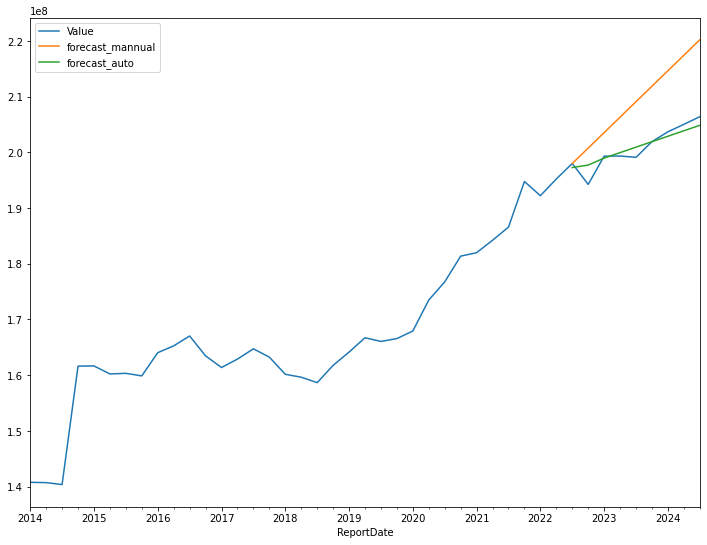

In [24]:
# Plot forecasts with entire dataset

df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)
df.plot(figsize=(12,9))

<AxesSubplot:xlabel='ReportDate', ylabel='Value'>

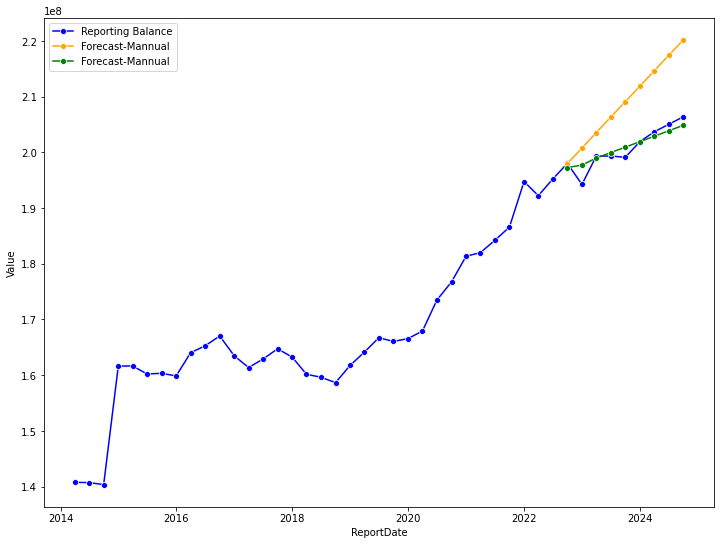

In [25]:
# Plot using seaborn

plt.figure(figsize=(12, 9))

sns.lineplot(x='ReportDate', y='Value', data=df, label='Reporting Balance', color='blue', marker='o')
sns.lineplot(x='ReportDate', y='forecast_mannual', data=df, label='Forecast-Mannual', color='orange', marker='o')
sns.lineplot(x='ReportDate', y='forecast_auto', data=df, label='Forecast-Mannual', color='green', marker='o')

In [26]:
# Calculate model performance metric: mean absolute error
# A mean of absolute difference between test values and forecast values

mae_arima_012 = mean_absolute_error(df_test, forecast_test)
print(f"MAE - ARIMA model mannual: {mae_arima_012}")

mae_arima_013 = mean_absolute_error(df_test, forecast_test_auto)
print(f"MAE - ARIMA model auto: {mae_arima_013}")

MAE - ARIMA model mannual: 8319091.27637877
MAE - ARIMA model auto: 1165347.7379034427


## 9. Evaluate Reporting Balance

In [27]:
# Utilize auto-fit ARIMA model

forecast_rslt, conf_int = auto_arima.predict(
    n_periods=len(df_test),
    return_conf_int=True,
    alpha=0.5
)

In [28]:
# Extract lower and upper bound of a 95% confidence internval

lower_bound = conf_int[:, 0]
upper_bound = conf_int[:, 1]

In [29]:
# Append confidence interval bounds

df['lower_bound'] = [None]*len(df_train) + list(conf_int[:, 0])
df['upper_bound'] = [None]*len(df_train) + list(conf_int[:, 1])

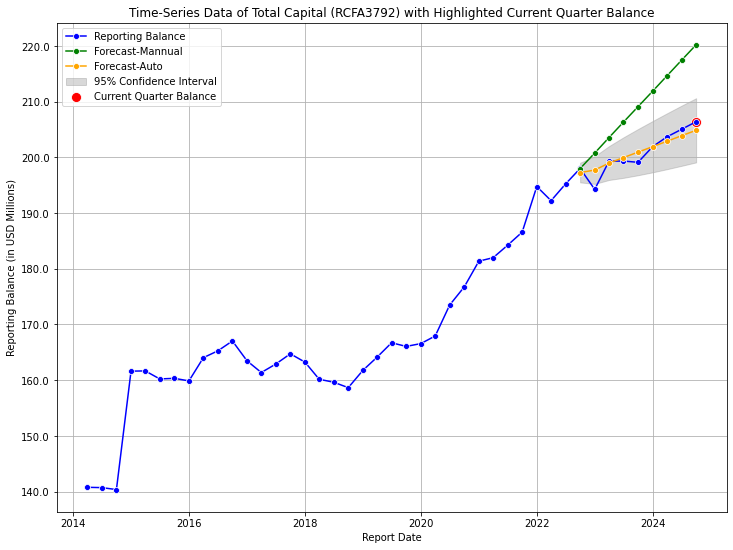

In [30]:
# Plot forecast with 95% condiference interval

plt.figure(figsize=(12, 9))

ax1 = sns.lineplot(x='ReportDate', y='Value', data=df, label='Reporting Balance', color='blue', marker='o')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))
ax2 = sns.lineplot(x='ReportDate', y='forecast_mannual', data=df, label='Forecast-Mannual', color='green', marker='o')
ax3 = sns.lineplot(x='ReportDate', y='forecast_auto', data=df, label='Forecast-Auto', color='orange', marker='o')

plt.fill_between(df.index, df['lower_bound'], df['upper_bound'], alpha=0.3, color='grey', label='95% Confidence Interval')
sns.scatterplot(x=[df.index[-1]], y=[df['Value'].iloc[-1]], color='red', s=100, label='Current Quarter Balance')

plt.xlabel('Report Date')
plt.ylabel('Reporting Balance (in USD Millions)')
plt.title('Time-Series Data of Total Capital (RCFA3792) with Highlighted Current Quarter Balance')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Extract the most recent quarter
df_trend = df.tail(1)

# Determine whether the current quarter balance is off the trend
df_trend['off_trend'] = ['Yes' if val < lower or upper < val else 'No'
                         for val, lower, upper in zip(df_trend['Value'], df_trend['lower_bound'], df_trend['upper_bound'])]

df_trend

,Value,forecast_mannual,forecast_auto,lower_bound,upper_bound,off_trend
ReportDate,,,,,,
2024-09-30,206410000.0,2.202181e+08,2.048662e+08,1.991058e+08,2.106265e+08,No


Therefore, based on forecast values predicted by ARIMA(0,1,3) model, the current reporting balance of 09/30/2024 is within a predictable range, which concludes that it is not off the trend.